In [31]:
import re
import random
import pandas as pd
import hashlib

In [32]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [33]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
WinHex,39.593312,1.885396,9.766567,21
"The Simulacra, Dick",335.546059,17.660319,37.388897,19
Windows PATH Variable,707.576833,23.585894,77.905019,30
Terraform,52.262945,26.131472,28.225571,2
Node.JS and React,1218.543686,39.307861,117.025257,31
Azure Compute Gallery,341.901542,48.843077,86.815889,7
"Mexican Gothic, Moreno-Garcia",1428.859383,51.030692,202.417268,28
Django,2326.139630,58.153491,235.677804,40
Azure Functions Core Tools,1048.133097,61.654888,154.786113,17
Azure Files Documentation,3852.459308,67.587005,251.656583,57


# Histogram

sum of ages: ~49871.80


<Axes: >

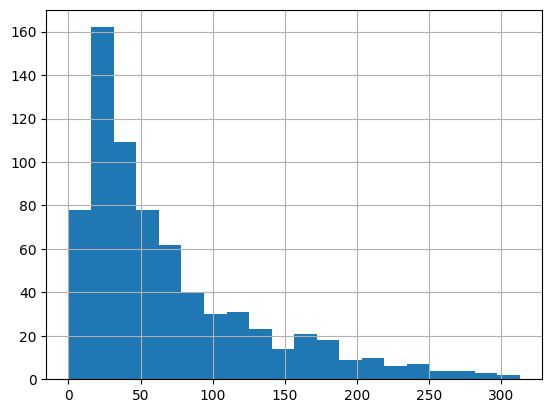

In [34]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~49871.80


<Axes: >

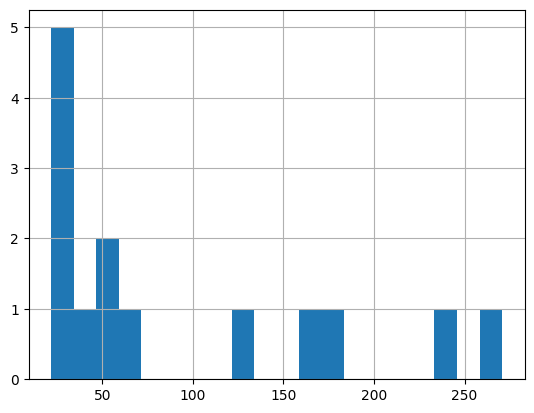

In [35]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Vocab']['age'].hist(bins=20)

# Completely Random Shuffle

In [36]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [37]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [38]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [39]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [40]:
n = random.choice([2, 3, 3, 4, 5])

existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 711
Total card age: 49871.80


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Microsoft Purview,Run the policy in simulation mode with notific...,3a95ac540d1e377383ba60aeb1da4f08,312.724598,78.090161,-312.724598,3748.327725,0.471327,48,0,0,-312.724598
1,Microsoft Purview,For organization-wide data consumers:\n Dat...,e30fb539c4e7b3fd2937525e3328ed8a,296.011319,78.090161,-312.724598,3748.327725,0.471327,48,1,0,-296.011319
2,Microsoft Purview,Evaluate the impact of the controls by impleme...,b027800e97a28f1c1158acc7cfc6eae2,247.676645,78.090161,-312.724598,3748.327725,0.471327,48,2,0,-247.676645
4,JavaScript Concepts,The basic syntax for a string template in Java...,950e996ffe32215d3aa7bacc2d81cc26,305.236672,88.526492,-305.236672,3364.006680,0.264361,38,0,0,-305.236672
5,JavaScript Concepts,await\nPauses execution of its enclosing async...,d4cb1253a35761e311d04f6f4373e687,202.678929,88.526492,-305.236672,3364.006680,0.264361,38,1,0,-202.678929
6,JavaScript Concepts,Logical AND (&&) and OR (||) Statements\nif (c...,8541c9ae716e3f5474869ab92784fcc8,186.037095,88.526492,-305.236672,3364.006680,0.264361,38,2,0,-186.037095
8,Terraform Codebox,path.module in Terraform refers to the directo...,0077d1efc41777feb76ac15cfa44de56,294.792823,92.172764,-294.792823,3594.737804,0.665948,39,0,0,-294.792823
9,Terraform Codebox,Terraform allows you to target specific parts ...,93c4df9dde5484c019ce7758b6524728,260.479152,92.172764,-294.792823,3594.737804,0.665948,39,1,0,-260.479152
10,Terraform Codebox,TF_LOG=DEBUG is an environment variable that m...,eb9c36cb0f05a2fd3b6125a9e1fbbab7,258.585221,92.172764,-294.792823,3594.737804,0.665948,39,2,0,-258.585221
12,Active Directory and Azure Files,Kerberos Key (Storage Account key)\nA secret (...,7c008b725311d3b542f19e49340e719d,286.415172,84.296153,-286.415172,3034.661492,0.120422,36,0,0,-286.415172


## Card Count

In [41]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [42]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [43]:
existing_cards.head(10)['age'].sum()

np.float64(2650.637625997887)

In [44]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Microsoft Purview,Run the policy in simulation mode with notific...,3a95ac540d1e377383ba60aeb1da4f08,312.724598,78.090161,-312.724598,3748.327725,0.471327,48,0,0,-312.724598
4,JavaScript Concepts,The basic syntax for a string template in Java...,950e996ffe32215d3aa7bacc2d81cc26,305.236672,88.526492,-305.236672,3364.006680,0.264361,38,0,0,-305.236672
1,Microsoft Purview,For organization-wide data consumers:\n Dat...,e30fb539c4e7b3fd2937525e3328ed8a,296.011319,78.090161,-312.724598,3748.327725,0.471327,48,1,0,-296.011319
8,Terraform Codebox,path.module in Terraform refers to the directo...,0077d1efc41777feb76ac15cfa44de56,294.792823,92.172764,-294.792823,3594.737804,0.665948,39,0,0,-294.792823
12,Active Directory and Azure Files,Kerberos Key (Storage Account key)\nA secret (...,7c008b725311d3b542f19e49340e719d,286.415172,84.296153,-286.415172,3034.661492,0.120422,36,0,0,-286.415172
16,Python + Oauth2.0,http.server.SimpleHTTPRequestHandler\n\nA buil...,142b6319783bfbbf45e56e053e9a4c0c,276.950993,98.184739,-276.950993,2061.879519,0.033356,21,0,0,-276.950993
20,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,273.431462,72.585026,-273.431462,2975.986061,0.978727,41,0,0,-273.431462
17,Python + Oauth2.0,redirect_uri\n\nThe URL where the OAuth provid...,0f71673850ec4ac81e9d1d446c5f48a9,272.268787,98.184739,-276.950993,2061.879519,0.033356,21,1,0,-272.268787
24,Vocab,"Jingo, Pratchett\nCruet\nnoun | KROO-it\nA sma...",528220646783dfd409ce4f2edf53a104,270.712223,93.094413,-270.712223,1303.321776,0.082470,14,0,0,-270.712223
28,Asynchronous Python,return_exceptions=True (in gather)\nA paramete...,7b43de3dee4f46aa5adbf4020aff8165,262.551322,96.611514,-262.551322,1642.395738,0.449067,17,0,0,-262.551322


In [45]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 70.143'